In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy

from sklearn.neighbors import KNeighborsClassifier


from tqdm import tqdm

In [32]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Sex'
value_to_predict = 'population'


********************
None
xgboost
chrXY
********************


5it [04:43, 56.79s/it]


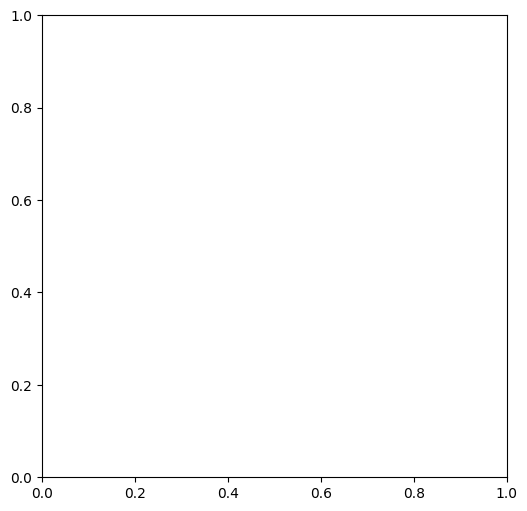

In [82]:
result_dict = {}
for organ in ['None']:
    result_dict[organ] = {}
    # for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    for sex in ['chrXY']:
        result_dict[organ][sex] = {}

        print("*" * 20)
        print(organ)
        print(model_type)
        print(sex)
        print("*" * 20)
        
        with open(ml_models_fdir/f'{model_type}.json', 'r') as file:
            model_params = json.load(file)
        model_params = model_params[value_to_predict]

        data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)

        # features = pd.read_hdf(
        #     fdir_processed / f'feature_importance.{model_type}.{"Sex"}.organ_{organ}.h5',
        #     key=f'{sex}',
        # )
        features = data.columns
    
        data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')

        X = data.values
        y = data_header[value_to_predict]

        label_encoder = LabelEncoder().fit(y)
        y = label_encoder.transform(y)

        # label_encoder = OneHotEncoder().fit(pd.DataFrame(y))
        # y = y.astype('category')        

        cv = StratifiedKFold(n_splits=5)

        fig, ax = plt.subplots(figsize=(6, 6))
        for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]

            # train_scaler = StandardScaler().fit(X_train)
            # test_scaler = StandardScaler().fit(X_test)

            train_scaler = RobustScaler().fit(X_train)
            test_scaler = RobustScaler().fit(X_test)

            X_train = train_scaler.transform(X_train)
            X_test = test_scaler.transform(X_test)
            
            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test

            # y_val = label_encoder.transform(pd.DataFrame(y_val)).toarray()
            # y_train_= label_encoder.transform(pd.DataFrame(y_train_)).toarray()

            model_params['enable_categorical'] = True

            model = xgb.XGBClassifier(**model_params)
            model.fit(cupy.array(X_train_), y_train_, eval_set=[(X_val, y_val)], verbose=False)

            pred = model.predict(cupy.array(X_test))
            pred_prob = model.predict_proba(cupy.array(X_test))

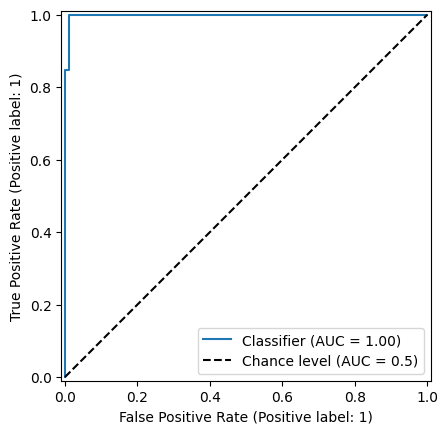

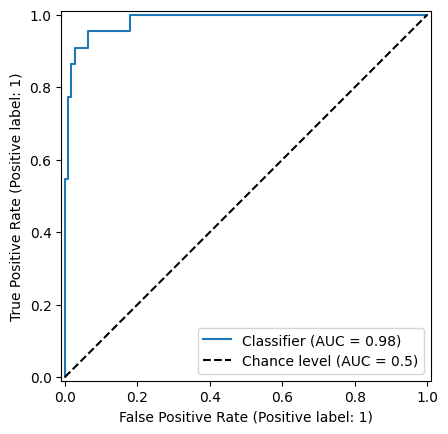

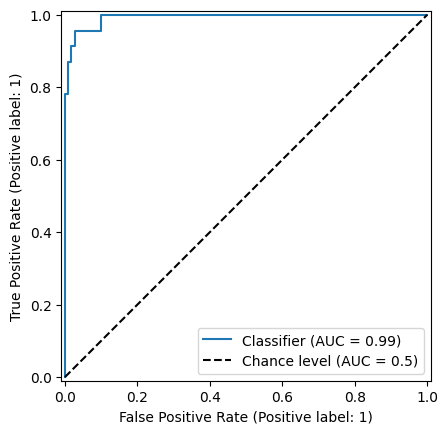

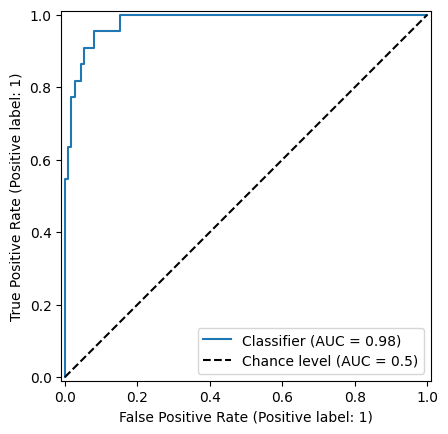

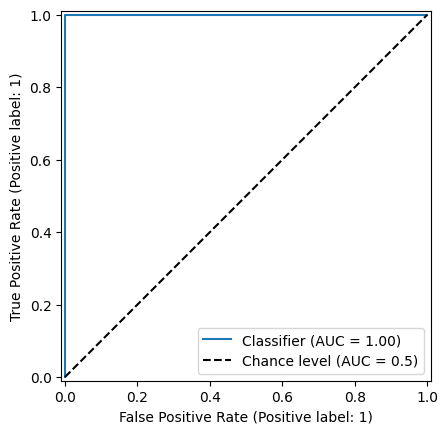

In [83]:
for i in range(pred_prob.shape[1]):
    RocCurveDisplay.from_predictions(
        LabelBinarizer().fit_transform(y_test)[:,i], pred_prob[:,i],
        plot_chance_level=True
)

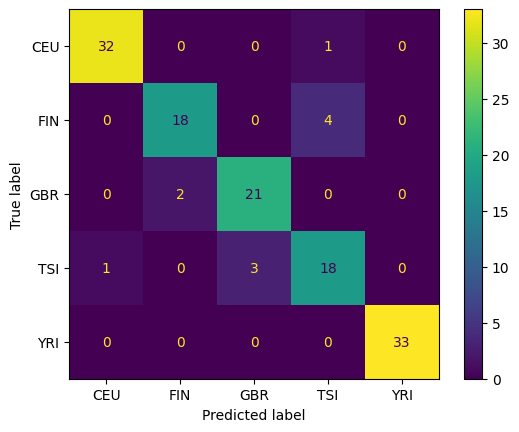

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred=pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot()


array([0, 1, 2, 3, 4])